In [1]:
using Plots, StatsBase, LinearAlgebra, Statistics, JLD2, Dates, StaticArrays, JSON, CUDA

In [2]:
M_list_big = Array{Any}(undef, 20, 20)
echoes_big = Array{Any}(undef, 20, 20)

@load "cpmg_100x100_α_vs_τe_echoes_12.jld2" echoes;
@load "cpmg_100x100_α_vs_τe_M_list_12.jld2" M_list;

echoes1 = echoes;
M_list1 = M_list;

@load "cpmg_100x100_α_vs_τe_echoes_20.jld2" echoes;
@load "cpmg_100x100_α_vs_τe_M_list_20.jld2" M_list;

echoes2 = echoes;
M_list2 = M_list;

for i = 1:20
    for j = 1:20
        
        if j <= 12
            M_list_big[i,j] = M_list1[i,j]
            echoes_big[i,j] = echoes1[i,j]
        else
            M_list_big[i,j] = M_list2[i,j]
            echoes_big[i,j] = echoes2[i,j]
        end
    end
end

params = Dict()
fname = "cpmg_100x100_α_vs_τe_params.json"
open(fname, "r") do f
    global params
    params = JSON.parse(f);
end

println(params["α"])
α = params["α"]
println(round.(params["echo_time"]*1e6, digits = 2))
echo_times = params["echo_time"];
println(params["num_echoes"])
num_echoes = params["num_echoes"];

Any[0.0, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1]
[50.0, 63.16, 76.32, 89.47, 102.63, 115.79, 128.95, 142.11, 155.26, 168.42, 181.58, 194.74, 207.89, 221.05, 234.21, 247.37, 260.53, 273.68, 286.84, 300.0]
Any[30, 24, 20, 17, 15, 13, 12, 11, 10, 9, 8, 8, 7, 7, 6, 6, 6, 5, 5, 5]


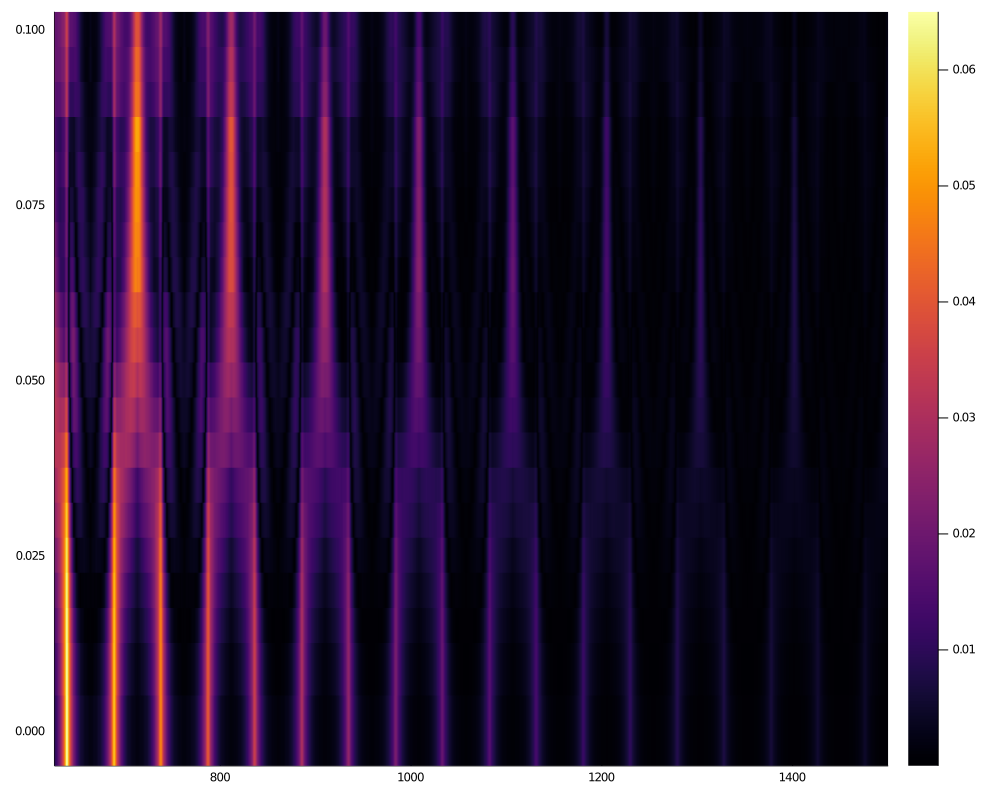

In [65]:
τe_idx = 1;

data = M_list_big[:,τe_idx]
a_data = Array{Any}(undef, 20, size(data[1],1))

for α_idx = 1:20
    a_data[α_idx, :] = data[α_idx]
end

a_data = broadcast(abs, a_data)

t = collect(LinRange(0, 1500, size(a_data,2)))
t0 = 2000
heatmap(t[t0:end], α, a_data[:,t0:end], size = (1000,800))

In [3]:
# calculate amplitudes and locations
# method index: index 1 = by max, index 2 = by integration

echo_ints = Array{Any}(undef, 20, 20, 2)
locs = Array{Any}(undef, 20, 20, 2)

for τe_idx = 1:20
    for α_idx = 1:20
        
        data = echoes_big[α_idx, τe_idx]
        data_cpmg = M_list_big[α_idx, τe_idx]
        L = length(data_cpmg) - size(data,1)*size(data,2)
        
        max_amps = []
        int_amps = []
        
        max_locs = []
        int_locs = []
        
        # do the first echo with the height of the initial point at the first point always
        amp = broadcast(abs, data_cpmg[1])
        loc = 1
        
        push!(max_amps, amp)
        push!(max_locs, loc)
        
        amp = 2*sum(broadcast(abs, data_cpmg[1:L]))
        loc = 1

        push!(int_amps, amp)
        push!(int_locs, loc)
        
        for echo_idx = 1:size(data,1)
            
            # maximum: loc = position of max, or average position of multiple max
            amp = maximum(broadcast(abs, data[echo_idx,:]))
            if length(amp) > 1
                amp = amp[1]
            end
            
            loc = findall(f -> f == amp, broadcast(abs, data[echo_idx,:]))
            if length(amp) > 1
                loc = average(loc)
            else
                loc = loc[1]
            end
            
            push!(max_amps, amp)
            push!(max_locs, loc)
                        
            # integral: loc = center of mass of echo
            amp = sum(broadcast(abs, data[echo_idx,:]))
            loc = 0
            for com_idx = 1:size(data,2)
                loc += broadcast(abs, data[echo_idx,com_idx])*com_idx
            end
            loc = convert(Int64, round(loc/amp))
                
            push!(int_amps, amp)
            push!(int_locs, loc)
            
        end
        
        echo_ints[α_idx, τe_idx, 1] = max_amps
        locs[α_idx, τe_idx, 1] = max_locs
        echo_ints[α_idx, τe_idx, 2] = int_amps*0.5/int_amps[1] # scaled so the first integral = 0.5
        locs[α_idx, τe_idx, 2] = int_locs
        
    end
end

new_locs = Array{Any}(undef, 20, 20, 2)
for α_idx = 1:20
    for τe_idx = 1:20
        for method_idx = 1:2
            temp = zeros(length(locs[α_idx, τe_idx, method_idx]))
            for i = 2:length(locs[α_idx, τe_idx, method_idx])
                temp[i] = locs[α_idx, τe_idx, method_idx][i] + size(echoes_big[α_idx, τe_idx],2)*(i-2) + length(M_list_big[α_idx, τe_idx]) - size(echoes_big[α_idx, τe_idx],2)*size(echoes_big[α_idx, τe_idx],1)
            end
            new_locs[α_idx, τe_idx, method_idx] = temp;
        end
    end
end

using LsqFit
@. model(x,p) = 0.5*exp(-x/p[1])
lb = [0.0, 0.0, 0.001]
ub = [0.5, 1.0, 1.0]
p0 = [0.0001]

dt = 2
γ = 2*pi*1e6

coefs = Array{Any}(undef, 20, 20, 2)
t2 = zeros(20, 20, 2)
plots = Array{Any}(undef, 20, 20, 2)

for α_idx = 1:20
    for τe_idx = 1:20
        for method_idx = 1:2
            
            y = echo_ints[α_idx, τe_idx, method_idx]
            x = new_locs[α_idx, τe_idx, method_idx]*(dt/γ)
            fit = curve_fit(model, x, y, p0)
            
            coefs[α_idx, τe_idx, method_idx] = coef(fit)
            t2[α_idx, τe_idx, method_idx] = coef(fit)[1]*1e6
            
            p = plot()
            t = collect(1:length(M_list_big[α_idx, τe_idx]))*(dt/γ)
            t_long = LinRange(0, length(M_list_big[α_idx, τe_idx])*(dt/γ), 10000)
            plot!(t*1e6, broadcast(abs, M_list_big[α_idx, τe_idx]), label = "CPMG")
            plot!(t_long*1e6, model(t_long, coef(fit)), label = "Exponential Fit")
            scatter!(x*1e6, y, label = "Echo Amplitudes")
            if τe_idx ∈ [17, 18, 19, 20]
                xlabel!("Time (μs)")
            end
            if τe_idx ∈ [1, 5, 9, 13, 17]
                ylabel!("Signal (arb. u.)")
            end
            title!("τe = "*string(round(echo_times[τe_idx]*1e6, digits = 2))*"μs")
            plots[α_idx, τe_idx, method_idx] = p;
            
        end
    end
end

In [283]:
## subtract off the curve fit for μ1 and μ2???
## include absolute values for μ1?

# calculate moments
μ1 = Array{Any}(undef, 20, 20)
μ2 = Array{Any}(undef, 20, 20)

for α_idx = 1:20
    for τe_idx = 1:20
        
        data = broadcast(abs, echoes_big[α_idx, τe_idx])
        
        μ1_temp = []
        μ2_temp = []
        for i = 1:size(data,1)
            μ1_h = 0
            μ2_h = 0
            for j = 1:size(data,2)
                μ1_h += data[i,j]*(j-size(data,2)/2)/size(data,2)
                # μ2_h += data[i,j]*(j-size(data,2)/2)^3/size(data,2)^3
                μ2_h += data[i,j]*(j-size(data,2)/2)^2/size(data,2)^2
            end
            push!(μ1_temp, μ1_h)
            push!(μ2_temp, μ2_h)
        end
        
        μ1[α_idx, τe_idx] = μ1_temp
        μ2[α_idx, τe_idx] = μ2_temp
    end
end

# make the plots
μ_plots = Array{Any}(undef, 20, 20)
for α_idx = 1:20
    for τe_idx = 1:20
        
        μ1_h = μ1[α_idx, τe_idx]
        μ2_h = μ2[α_idx, τe_idx]
        p = plot()
        plot!(p, μ1_h, label = "First Moment")
        scatter!(p, μ1_h, label = "First Moment")
        plot!(p, μ2_h, label = "Second Moment")
        scatter!(p, μ2_h, label = "Second Moment")
        title!(p, "τe = "*string(round(echo_times[τe_idx]*1e6, digits = 2))*"μs")
        if τe_idx ∈ [17, 18, 19, 20]
            xlabel!("Echo Number")
        end
        if τe_idx ∈ [1, 5, 9, 13, 17]
            ylabel!("Moment")
        end
        
        μ_plots[α_idx, τe_idx] = p;
        
    end
end

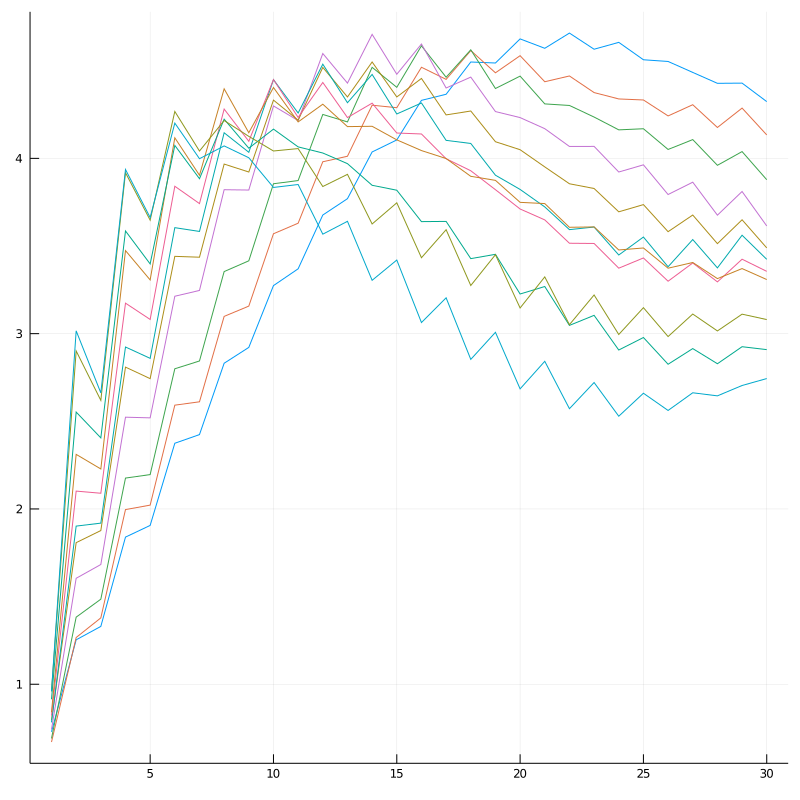

In [286]:
τe_idx = 1
p = plot(leg = false, size = (800, 800))
for α_idx = 10:20
    plot!(broadcast(abs, μ2[α_idx, τe_idx]./μ2[1, τe_idx]))
end
display(p)

In [246]:
for τe_idx = 1:20
    
    τe_str = string(convert(Int64, round(echo_times[τe_idx]*1e6)))
    t0 = echo_times[τe_idx]/2*1e6
    tf = (echo_times[τe_idx]/2 + echo_times[τe_idx]*num_echoes[τe_idx])*1e6

    p = plot(leg = false, size = (700, 500))
    for α_idx = 1:15
        t = LinRange(t0, tf, length(μ2[α_idx, τe_idx]))
        plot!(t, μ2[α_idx, τe_idx])
    end
    title!("μ2 vs t")
    xlabel!("Time (μs)")
    ylabel!("μ2")
    filename = "μ2_vs_t_τe_"*τe_str*".png"
    savefig(filename)
    
    p = plot(leg = false, size = (700, 500))
    for α_idx = 1:15
        t = LinRange(t0, tf, length(μ1[α_idx, τe_idx]))
        plot!(t, μ1_abs[α_idx, τe_idx])
    end
    title!("μ1 vs t")
    xlabel!("Time (μs)")
    ylabel!("μ1")
    filename = "μ1_vs_t_τe_"*τe_str*".png"
    savefig(filename)
end

In [33]:
for α_idx = 1:20

    α_str = split(string(α[α_idx]), ".")
    α_str = α_str[1]*"p"*α_str[2]
    
    method_idx = 1
    p = plot(leg = false)

    plot!(p, echo_times*1e6, round.(t2[α_idx,:,method_idx], digits = 3))
    scatter!(p, echo_times*1e6, round.(t2[α_idx,:,method_idx], digits = 3))
    title!(p, "T2 vs Echo Time, α = "*string(α[α_idx]));
    xlabel!(p, "Echo Time (μs)")
    ylabel!(p, "T2 (μs)")
    ylims!(minimum(round.(t2[α_idx,:,method_idx], digits = 3))-2, maximum(round.(t2[α_idx,:,method_idx], digits = 3))+2)
    
    filename = "t2_vs_τe_α_"*α_str*".png"
    savefig(filename)

    plt = plot(plots[α_idx,1,method_idx], plots[α_idx,2,method_idx], plots[α_idx,3,method_idx], plots[α_idx,4,method_idx], 
               plots[α_idx,5,method_idx], plots[α_idx,6,method_idx], plots[α_idx,7,method_idx], plots[α_idx,8,method_idx], 
               plots[α_idx,9,method_idx], plots[α_idx,10,method_idx], plots[α_idx,11,method_idx], plots[α_idx,12,method_idx], 
               plots[α_idx,13,method_idx], plots[α_idx,14,method_idx], plots[α_idx,15,method_idx], plots[α_idx,16,method_idx],
               plots[α_idx,17,method_idx], plots[α_idx,18,method_idx], plots[α_idx,19,method_idx], plots[α_idx,20,method_idx],
               layout = (5,4), size = (2000,2000))


    filename = "cpmgs_α_"*α_str*"_vs_τe.png"
    savefig(filename)
    
end

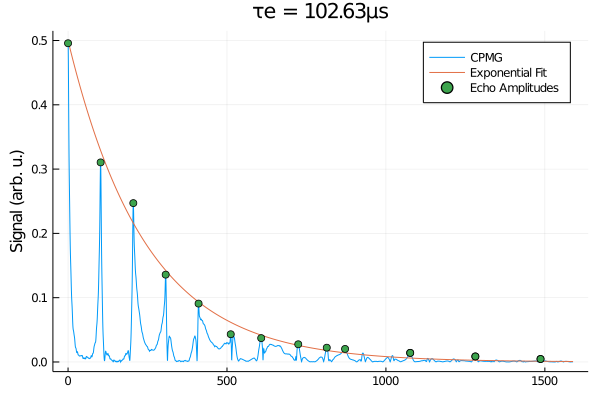

0.075


In [273]:
τe_idx = 5
p = plots[15,τe_idx,1]


display(p)
savefig("close_look.png")

In [200]:
@. model(x,p) = p[1] - p[2]*exp(-(x+p[4])*p[3])
p0 = [300, 50, 0.01, 1]

coefs2 = Array{Any}(undef, 20)
p1_list = []
p2_list = []
p3_list = []
p4_list = []

for α_idx = 1:20
            
    y = t2[α_idx,:,1]
    x = echo_times*1e6
    fit = curve_fit(model, x, y, p0)

    coefs2[α_idx] = coef(fit)
    push!(p1_list, coef(fit)[1])
    push!(p2_list, coef(fit)[2])
    push!(p3_list, coef(fit)[3])
    push!(p4_list, coef(fit)[4])

end

In [215]:
αf = 16

p1 = plot(leg = false)
scatter!(p1, α[1:αf], 1 ./p3_list[1:αf])
plot!(p1, α[1:αf], 1 ./p3_list[1:αf])
title!(p1, "Growth Rate of (T2 vs τe) vs α")
xlabel!(p1, "α")
ylabel!(p1, "Growth Rate (μs)")

p2 = plot(leg = false)
scatter!(p2, α[1:αf], p1_list[1:αf])
plot!(p2, α[1:αf], p1_list[1:αf])
title!(p2, "T2(τe = ∞) vs α")
xlabel!(p2, "α")
ylabel!(p2, "T2(τe = ∞) (μs)")

p3 = plot(leg = false)

yint = []
for α_idx = 1:20
    c = coefs2[α_idx]
    y = model(0,c)
    push!(yint, y)
end

scatter!(p3, α[1:αf], yint[1:αf])
plot!(p3, α[1:αf], yint[1:αf])
title!(p3, "T2(τe = 0) vs α")
xlabel!(p3, "α")
ylabel!(p3, "T2(τe = 0) (μs)")


p = plot(p1, p2, p3, layout = (1,3), size = (1200, 400))
savefig("T2_vs_τe_fits.png")
    

In [183]:
println(α[1:15])

Any[0.0, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075]


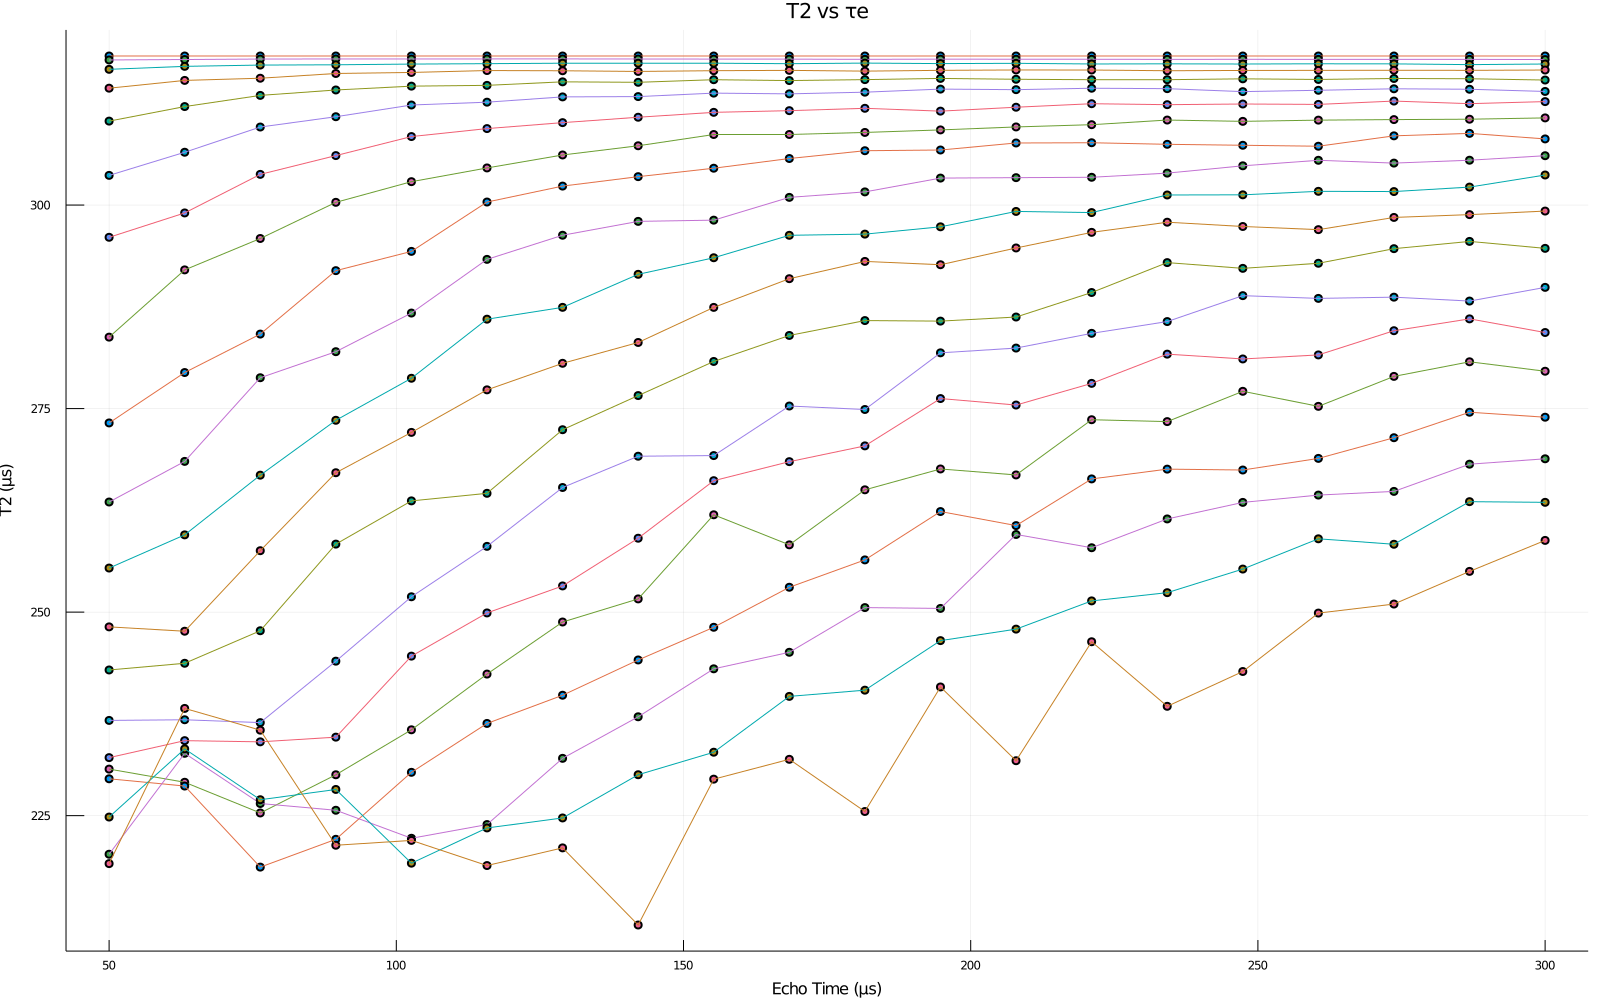

In [217]:
p = plot(size = (1600,1000))
for i = 1:20
    scatter!(echo_times*1e6, t2[i,:,1], leg = false)
    plot!(echo_times*1e6, t2[i,:,1], label = "α = "*string(α[i]));
    
    t = LinRange(40, 310, 10000)
    # plot!(t, model(t, coefs2[i]))
    
end
xlabel!("Echo Time (μs)")
ylabel!("T2 (μs)")
title!("T2 vs τe")

savefig("t2_vs_τe_full.png")

display(p)